# Neural Networks and Time Series

### Preceptron

In [14]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

digits = load_digits()

x = digits.data
y = digits.target

x = StandardScaler().fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=32)


nn = Perceptron()

nn.fit(x_train, y_train)

print('Scores ', nn.score(x_test, y_test))

Scores  0.9472222222222222


### Multi Layer Preceptron

In [32]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import pickle

boston = load_boston()

x = boston.data
y = boston.target


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.2, random_state=32)

scaling = MinMaxScaler(feature_range=(0,1)).fit(x_train)

x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

nn_reg = MLPRegressor(max_iter=300, hidden_layer_sizes={13,26,1}, shuffle=True, activation='tanh', solver='lbfgs', random_state=32)

nn_reg.fit(x_train, y_train)

pickle.dump(nn_reg, open('nn_reg.pkl', 'wb'))


loaded_model = pickle.load(open('nn_reg.pkl', 'rb'))

print("Score", loaded_model.score(x_test, y_test))

Score 0.7907909128791298


/opt/anaconda3/envs/inclassEnv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Time Series

In [33]:
import pandas as pd
import numpy as np


from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('Datasets/consumption.csv',sep=",")

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data


,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


### Creating Features

In [34]:
data_consumption = data[['Consumption']]

data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:, 'Consumption'].shift()

data_consumption.loc[:, 'Yesterday_Diff'] = data_consumption.loc[:, 'Yesterday'].diff()

data_consumption = data_consumption.dropna()

data_consumption

,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-03,1442.53300,1380.52100,311.33700
2006-01-04,1457.21700,1442.53300,62.01200
2006-01-05,1477.13100,1457.21700,14.68400
2006-01-06,1403.42700,1477.13100,19.91400
2006-01-07,1300.28700,1403.42700,-73.70400
...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345
2017-12-28,1299.86398,1263.94091,133.82408
2017-12-29,1295.08753,1299.86398,35.92307


### Setup Training data

In [35]:
X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption.loc[:'2016', 'Consumption']
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

X_train

,Yesterday,Yesterday_Diff
Date,,
2006-01-03,1380.521,311.337
2006-01-04,1442.533,62.012
2006-01-05,1457.217,14.684
2006-01-06,1477.131,19.914
2006-01-07,1403.427,-73.704
...,...,...
2016-12-27,1121.213,3.540
2016-12-28,1289.324,168.111
2016-12-29,1294.881,5.557


### Create Models and Test

In [36]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(kernel='rbf', gamma='auto'))) # kernel = linear

results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))



LR: 0.343747 (0.029773)
NN: 0.513432 (0.119472)
KNN: 0.646307 (0.083185)
RF: 0.617134 (0.071586)
SVR: -0.117944 (0.157755)


### Plot Algorithms

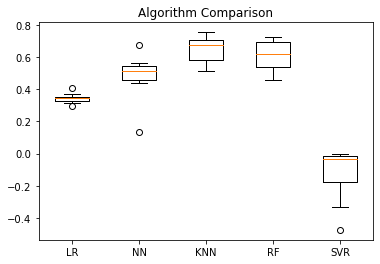

In [44]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

### Choose Best Model

In [46]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [i for i in range(5,10)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_


print(best_model)

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=50)


### Apply to X_test

In [48]:
from sklearn.metrics import r2_score

y_pred = best_model.predict(X_test)

print("accuracy", r2_score(y_test, y_pred))

accuracy 0.7275736253800164


### Add more features

In [50]:
data_consumption_2o = data_consumption.copy()
# inserting column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption_2o['Yesterday-1_Diff'] = data_consumption_2o['Yesterday-1'].diff()
# dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

data_consumption_2o

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
Date,,,,,
2006-01-05,1477.13100,1457.21700,14.68400,1442.53300,62.01200
2006-01-06,1403.42700,1477.13100,19.91400,1457.21700,14.68400
2006-01-07,1300.28700,1403.42700,-73.70400,1477.13100,19.91400
2006-01-08,1207.98500,1300.28700,-103.14000,1403.42700,-73.70400
2006-01-09,1529.32300,1207.98500,-92.30200,1300.28700,-103.14000
...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408


### Creating Training data

In [52]:
X_train_2o = data_consumption_2o[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o = data_consumption_2o.loc[:'2016', 'Consumption']
X_test = data_consumption_2o['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o.loc['2017', 'Consumption']

X_train_2o

,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
Date,,,,
2006-01-05,1457.217,14.684,1442.533,62.012
2006-01-06,1477.131,19.914,1457.217,14.684
2006-01-07,1403.427,-73.704,1477.131,19.914
2006-01-08,1300.287,-103.140,1403.427,-73.704
2006-01-09,1207.985,-92.302,1300.287,-103.140
...,...,...,...,...
2016-12-27,1121.213,3.540,1117.673,-77.681
2016-12-28,1289.324,168.111,1121.213,3.540
2016-12-29,1294.881,5.557,1289.324,168.111


### Using X_Test

In [54]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [i for i in range(5,10)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)

from sklearn.metrics import r2_score

y_pred = best_model.predict(X_test)

print("accuracy", r2_score(y_test, y_pred))

accuracy 0.8354159423936701
